In [1]:
import os
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import seaborn as sns

from gensim.models import KeyedVectors
from sentence_transformers import SentenceTransformer
import zipfile

/Users/michaela/anaconda3/envs/nlp/lib/python3.11/site-packages/sentence_transformers/cross_encoder/CrossEncoder.py:13: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm, trange


In [2]:
# Data Loading
data_path = os.path.join("data", "data_eda.zip")
data = pd.read_csv(data_path)
data.head()

,product,narrative,narrative_len,narrative_prep,text_lemma,narrative_prep_len,sentiment
0,credit_card,purchase order day shipping amount receive pro...,230,purchase order day shipping receive product we...,purchase order day shipping receive product we...,203,0.078905
1,credit_card,forwarded message date tue subject please inve...,132,forwarded message date tue subject investigate...,forward message date tue subject investigate c...,121,-0.016748
2,retail_banking,forwarded message cc sent friday pdt subject f...,173,forwarded message cc sent friday pdt subject f...,forward message cc send friday pdt subject fin...,147,-0.010000
3,credit_reporting,payment history missing credit report speciali...,131,payment history missing credit report speciali...,payment history miss credit report specialized...,110,0.061483
4,credit_reporting,payment history missing credit report made mis...,123,payment history missing credit report mistake ...,payment history miss credit report mistake acc...,102,0.061483


***Goal: Try out different embeddings to see, how (or if) the product categories can be clustered by cosine similarity.***

In [3]:
# write a function to get and plot cosine similiraty by product category
def plot_cosine_similarity(embeddings, name):
    cosine_sim = cosine_similarity(embeddings)
    # plot the cosine similarity matrix
    sns.heatmap(cosine_sim, annot=True, cmap='coolwarm',
                xticklabels=embeddings.index,
                yticklabels=embeddings.index
                ).set_title("Cosine Similarity Matrix for " + name)  

1) TFIDF on lemmatized text

In [4]:
# Create a TF-IDF vectorizer and fit it on the complaints
vectorizer = TfidfVectorizer(max_features=1000, stop_words='english')
tfidf_matrix = vectorizer.fit_transform(data['text_lemma'])
# Convert to a dataframe for easier manipulation
tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), columns=vectorizer.get_feature_names_out())

In [5]:
# Add the categories back to the dataframe
tfidf_df['product'] = data['product'].values
# Group by category and calculate the average TF-IDF values for each
category_embeddings = tfidf_df.groupby('product').mean()

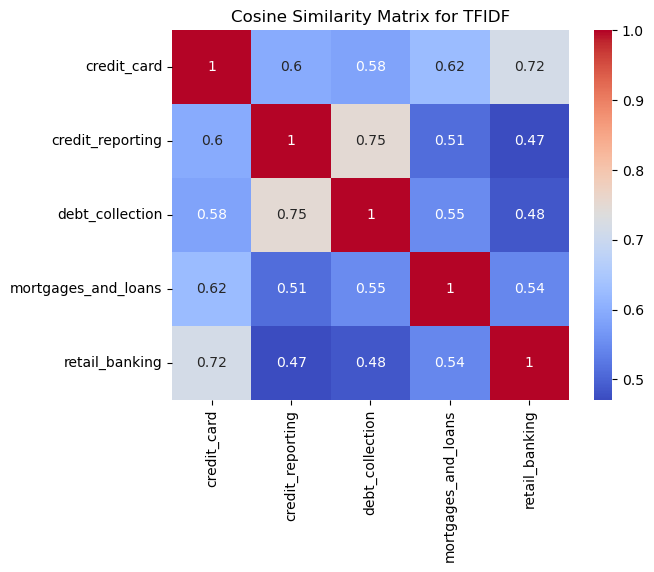

In [6]:
plot_cosine_similarity(category_embeddings, "TFIDF")

2) GLOVE on lemmatized text

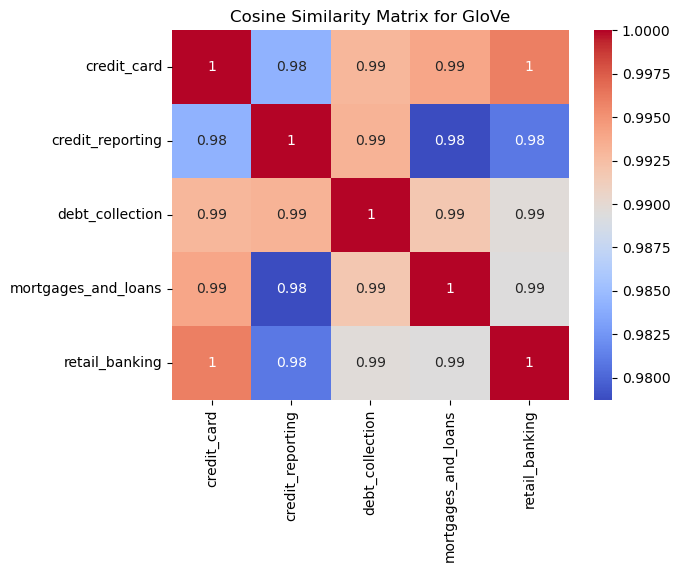

In [7]:
# Load the model
def load_glove_model():
    zip_path = os.path.join("data", "glove.6B.100d.zip")
    glove_file = os.path.join("data", "glove.6B.100d.txt")

    #unzip the file if not already unzipped
    if not os.path.exists(glove_file):
        with zipfile.ZipFile(zip_path, 'r') as zip_ref:
            zip_ref.extractall("data")
        
    glove_model = {}
    with open(glove_file, 'r', encoding='utf-8') as f:
        for line in f:
            values = line.split()
            word = values[0]
            vector = np.array(values[1:], dtype='float32')
            glove_model[word] = vector
    return glove_model

# Get the average GloVe embedding for a complaint
def get_average_embedding(text, glove_model):
    words = text.split()
    embeddings = []
    for word in words:
        if word in glove_model:
            embeddings.append(glove_model[word])
    if embeddings:
        return np.mean(embeddings, axis=0)
    else:
        return np.zeros(100)

# Load Model and get embeddings
glove_model = load_glove_model()
#get_embedding(data["text_lemma"][0], glove_model)
glove_df = data['text_lemma'].apply(lambda x: get_average_embedding(x, glove_model)).to_frame()
glove_df['product'] = data['product'].values
glove_df = glove_df.groupby('product')['text_lemma'].apply(np.mean)
glove_df = pd.DataFrame(glove_df.tolist(), index=glove_df.index)
glove_df
plot_cosine_similarity(glove_df, "GloVe")


3) Sentence transformers on unleammatized text:

In [8]:
model = SentenceTransformer('all-MiniLM-L6-v2')

/Users/michaela/anaconda3/envs/nlp/lib/python3.11/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [9]:
sbert = model.encode(data["narrative_prep"])

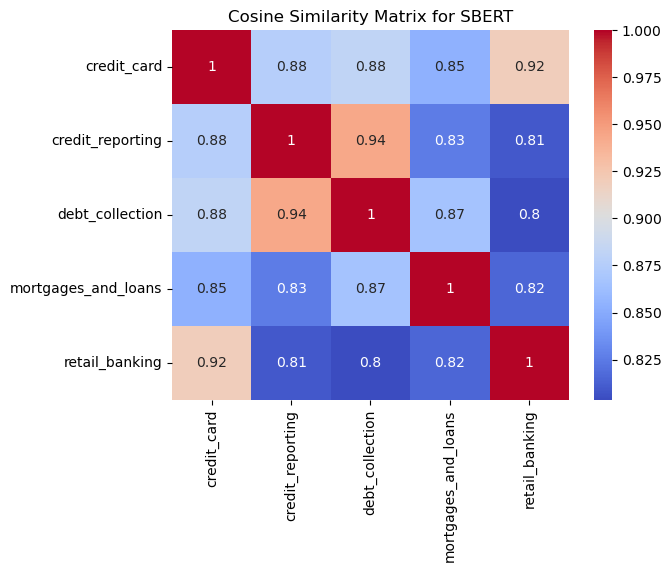

In [10]:
sbert_df = pd.DataFrame(sbert)
sbert_df['product'] = data['product'].values
sbert_df = sbert_df.groupby('product').mean()
plot_cosine_similarity(sbert_df, "SBERT")